In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Activation, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
import random
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adamax
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir

In [ ]:
base_directory = 'brain-tumor-mri-dataset'
Training , Testing = 'Training', 'Testing'
List_labels = os.listdir(base_directory+'/'+Training)
target_size = (299 , 299)
num_classes = 4
labels = {}
for key in range(len(list(List_labels))):
    labels[List_labels[key]] = key

In [ ]:
labels

{'pituitary': 0, 'notumor': 1, 'meningioma': 2, 'glioma': 3}

In [ ]:
def plot_sample_iamges(dataset_type , num_images = 4 , target_size = (299 ,299)):

    datasetpath = os.path.join(base_directory , dataset_type)

    fig, axes = plt.subplots(len(List_labels), num_images, figsize=(15, 10))


    for row,label in enumerate(List_labels):

        category_path = os.path.join(datasetpath, label)

        image_filenames = random.sample(os.listdir(category_path) , num_images)

        for col , image_filename in enumerate(image_filenames):
          while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
          image_path = os.path.join(category_path , image_filename)
          image = Image.open(image_path).resize(target_size)
          axes[row, col].imshow(image, cmap='gray')
          axes[row, col].axis('off')
          axes[row, col].set_title(f"{label}")

    plt.tight_layout()
    plt.show()

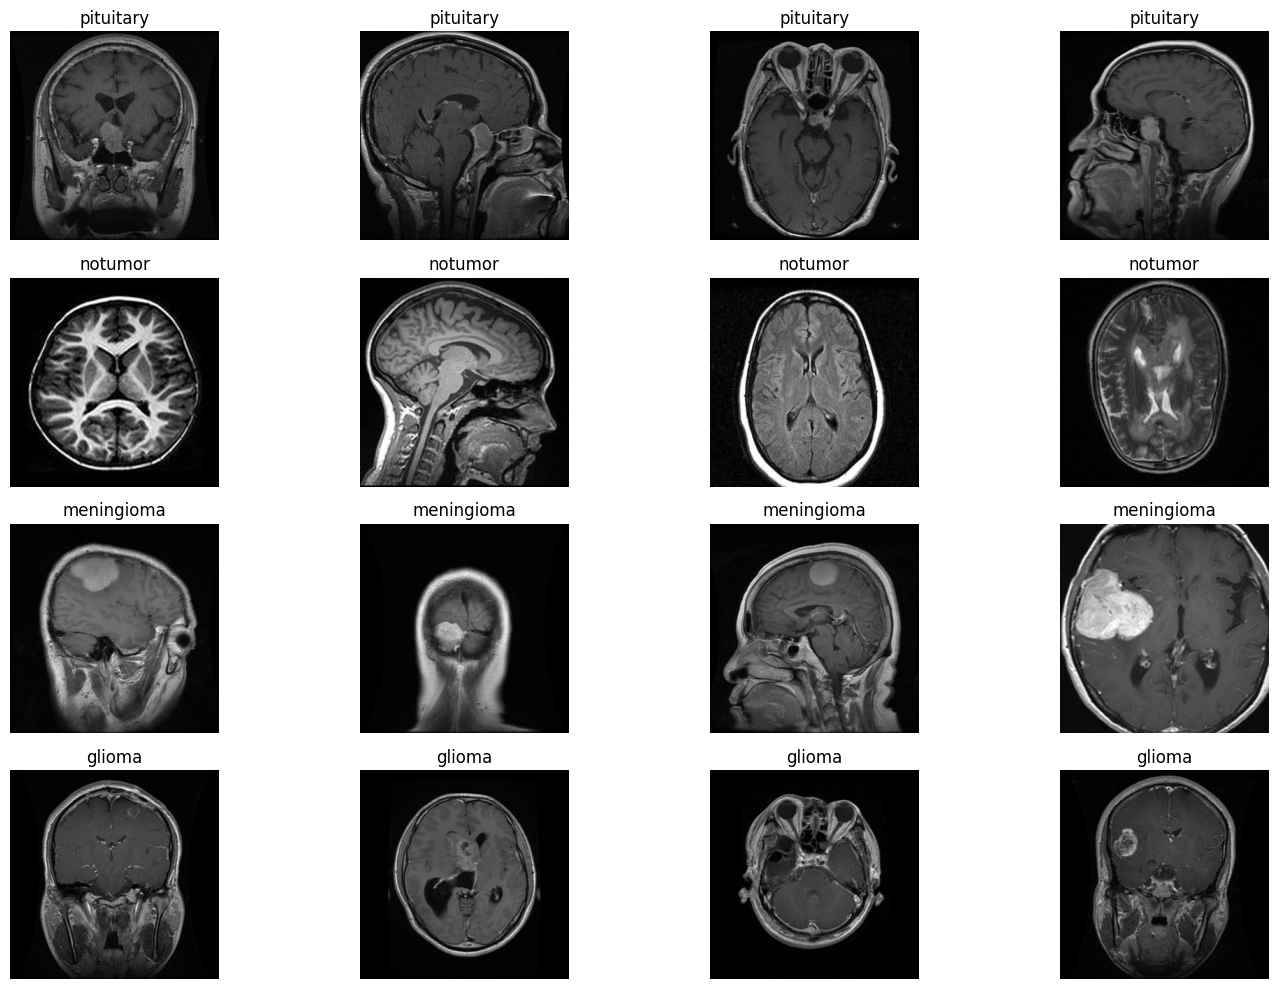

In [ ]:
plot_sample_iamges(Training)

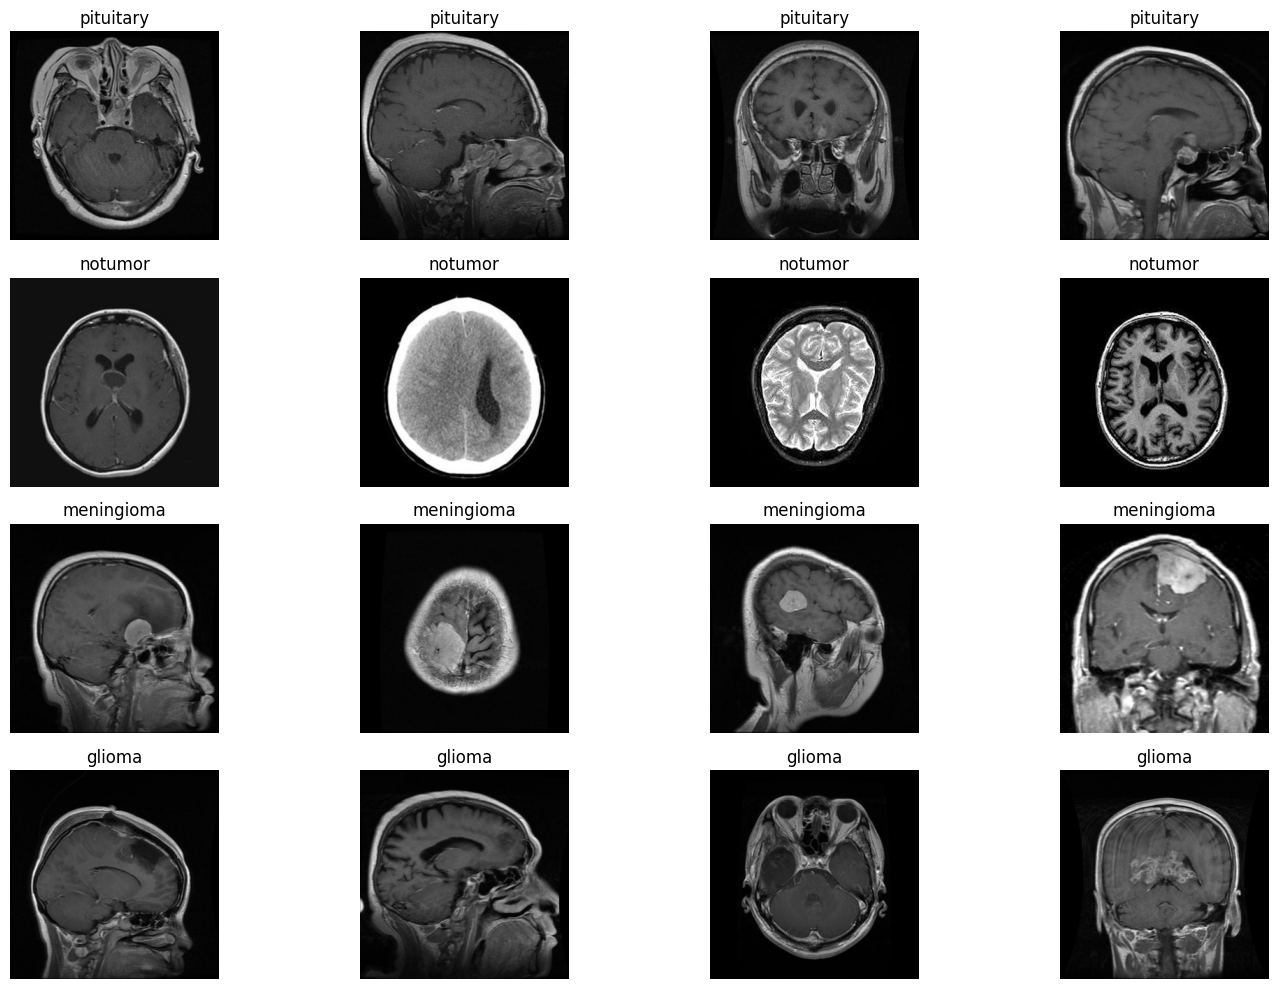

In [ ]:
plot_sample_iamges(Testing)

In [ ]:
def plot_class_distribution(datasettype):
    path = os.path.join(base_directory , datasettype)
    counts = [len(os.listdir(os.path.join(path , cat))) for cat in List_labels]

    plt.bar(List_labels , counts , color =['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("class")
    plt.ylabel("Number of Images")
    plt.title(f"{datasettype.capitalize()} Set Distribution")
    plt.show()

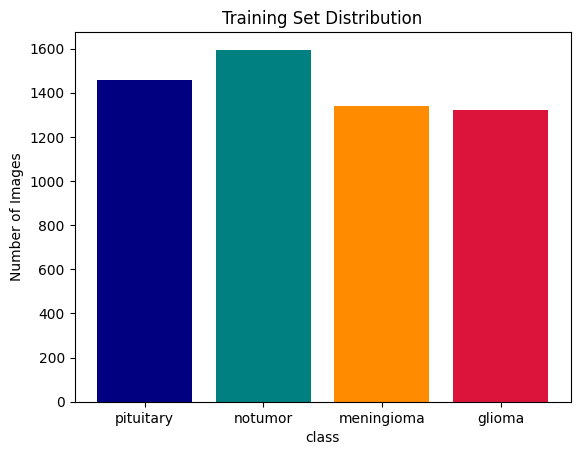

In [ ]:
plot_class_distribution(Training)

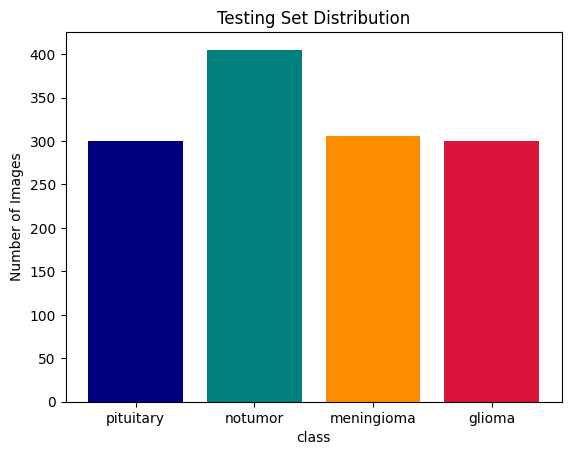

In [ ]:
plot_class_distribution(Testing)

In [ ]:
def create_dataset(path):
    my_list = []
    for label in List_labels:
        category_path = os.path.join(path , label)
        for file_name in os.listdir(category_path):
            image = os.path.join(category_path , file_name)
            if os.path.isfile(image) and image.lower().endswith(('.png', '.jpg', '.jpeg')):
                                my_list.append([image, label])
    return pd.DataFrame(my_list , columns = ['image' , 'label'])

In [ ]:
Train_df = create_dataset(base_directory+'/'+Training)
Test_df = create_dataset(base_directory+'/' + Testing)

In [ ]:
Train_df

,image,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [ ]:
Train_df['label'] = Train_df['label'].map(labels)
Test_df['label'] = Test_df['label'].map(labels)

In [ ]:
Train_df

,image,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,0
1,/kaggle/input/brain-tumor-mri-dataset/Training...,0
2,/kaggle/input/brain-tumor-mri-dataset/Training...,0
3,/kaggle/input/brain-tumor-mri-dataset/Training...,0
4,/kaggle/input/brain-tumor-mri-dataset/Training...,0
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,3
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,3
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,3
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,3


In [ ]:
test_df , val_df = train_test_split(Test_df , test_size = 0.5 , random_state = 42)

test_df = test_df.reset_index(drop = True)

val_df = val_df.reset_index(drop = True)

In [ ]:
batch_size = 32
img_size = (299, 299)
_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(Train_df, x_col='image',
                                  y_col='label', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(val_df, x_col='image',
                                     y_col='label', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(test_df, x_col='image',
                                  y_col='label', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = keras.models.Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
checkpoint = ModelCheckpoint('best-model/model_checkpoint.keras', save_best_only=True)
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False , callbacks=[checkpoint])

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 934ms/step - accuracy: 0.9967 - loss: 0.0097 - val_accuracy: 0.9832 - val_loss: 0.1113
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 911ms/step - accuracy: 0.9979 - loss: 0.0055 - val_accuracy: 0.9726 - val_loss: 0.2011
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 932ms/step - accuracy: 0.9961 - loss: 0.0095 - val_accuracy: 0.9802 - val_loss: 0.0838
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 907ms/step - accuracy: 0.9986 - loss: 0.0059 - val_accuracy: 0.9787 - val_loss: 0.1256
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 912ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9771 - val_loss: 0.0868
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 933ms/step - accuracy: 0.9981 - loss: 0.0052 - val_accuracy: 0.9878 - val_loss: 0.0671
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 168s 940ms/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.9924 - val_loss: 0.0346
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 912ms/step - accuracy: 1.0000 -

In [ ]:
history=hist.history

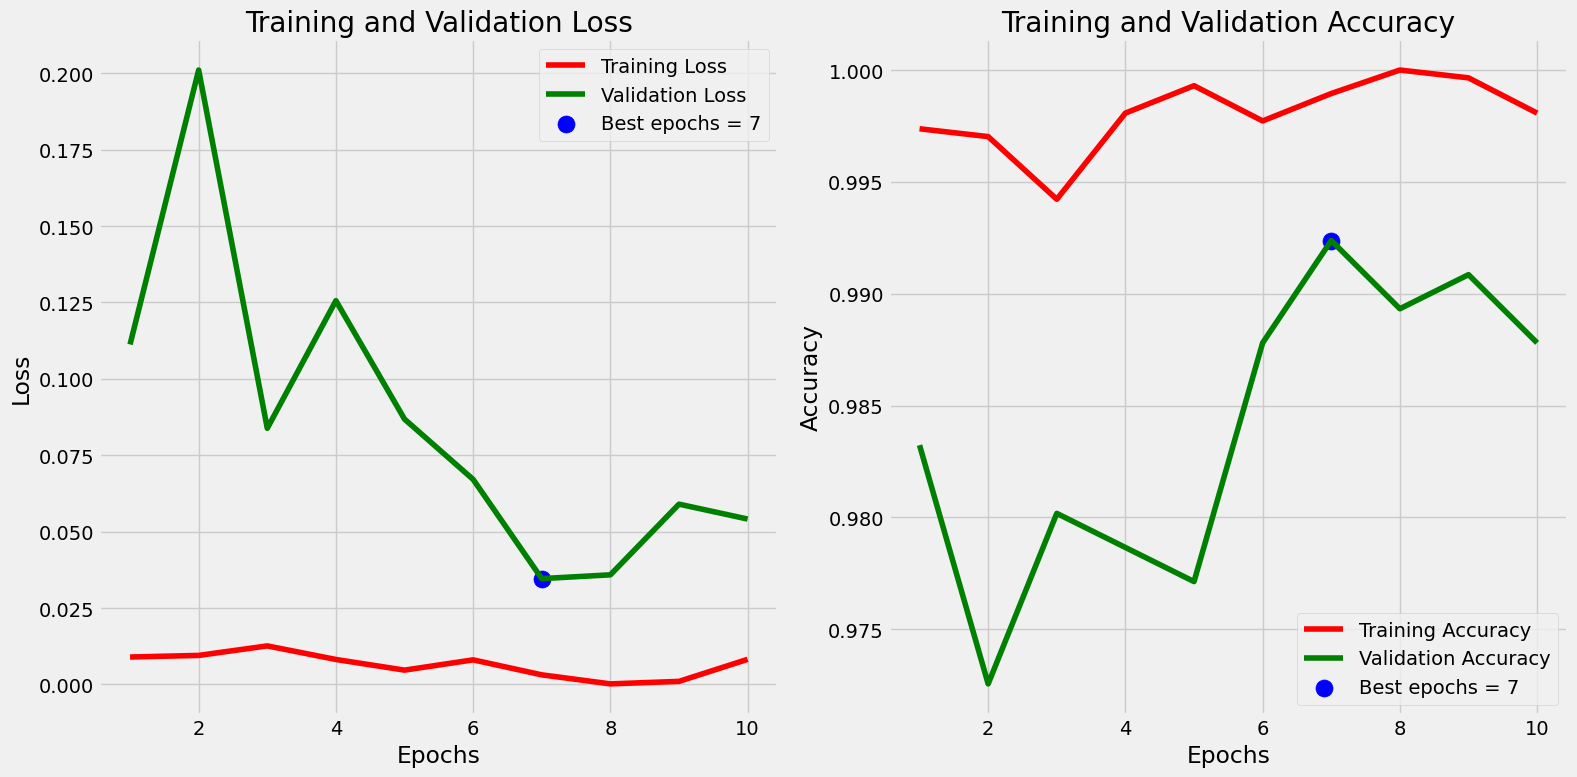

In [ ]:
train_acc = history['accuracy']
train_loss = history['loss']

val_acc = history['val_accuracy']
val_loss = history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(16,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('visulize_fr_MLP')
plt.legend()
plt.savefig('Brain_tumor_mob_net')
plt.tight_layout()
plt.show()

In [ ]:
best_model = load_model('best-model/model_checkpoint.keras')

In [ ]:
loss , acc = best_model.evaluate(ts_gen , verbose = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9965 - loss: 0.0289


In [ ]:
print(f"Test Loss: {round(loss,2)}")
print(f"Test Accuracy: {round(acc*100,2)}%")

Test Loss: 0.03
Test Accuracy: 99.54%


In [ ]:
y_pred_prob = best_model.predict(ts_gen , verbose =1 )

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step


In [ ]:
y_pred = np.argmax(y_pred_prob , axis = 1)

In [ ]:
print("\nClassification Report:\n", classification_report(ts_gen.labels, y_pred , target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


Classification Report:
               precision    recall  f1-score   support

      Glioma       1.00      0.98      0.99       151
  Meningioma       0.98      1.00      0.99       158
    No Tumor       1.00      1.00      1.00       197
   Pituitary       1.00      1.00      1.00       149

    accuracy                           1.00       655
   macro avg       1.00      1.00      1.00       655
weighted avg       1.00      1.00      1.00       655



In [ ]:
f1score = f1_score(ts_gen.labels, y_pred, average='macro')
precision=precision_score(ts_gen.labels, y_pred, average='macro')
recall = recall_score(ts_gen.labels, y_pred , average='macro')

In [ ]:
print(f"f1score: {round(f1score * 100. ,2)}%")
print(f"precision: {round(precision * 100 , 2)}%")
print(f"recall: {round(recall * 100 , 2)}%")

f1score: 99.51%
precision: 99.53%
recall: 99.5%


In [ ]:
cm = confusion_matrix(ts_gen.labels, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[148   3   0   0]
 [  0 158   0   0]
 [  0   0 197   0]
 [  0   0   0 149]]


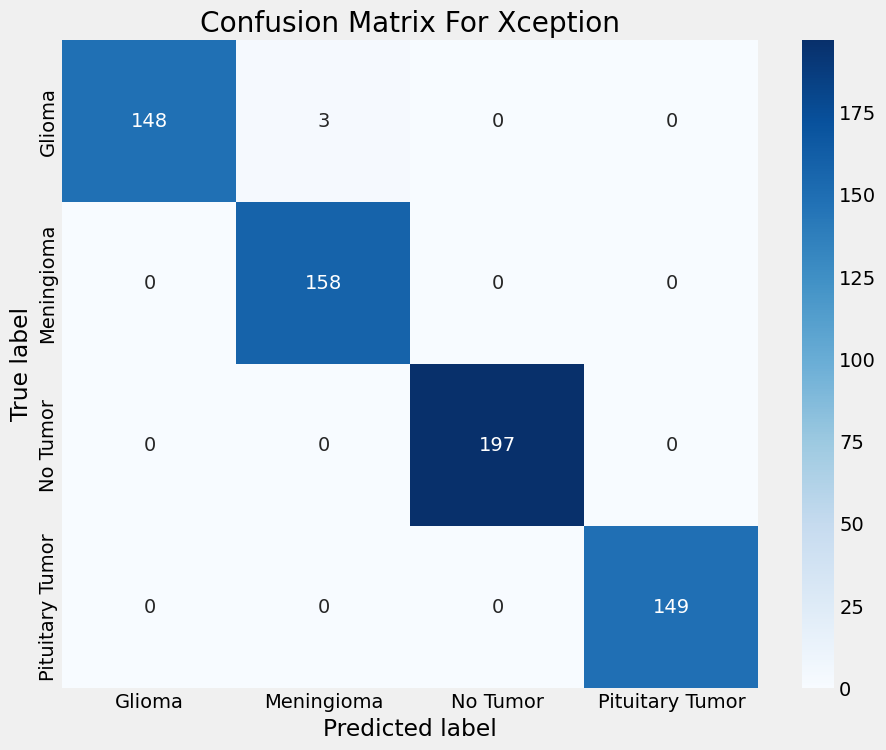

In [ ]:
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary Tumor']

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix For Xception")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig('confusion matrix for Xception.png')
plt.show()

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**99.08%** accuracy on the **test set**.<br>
**99.05%** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 99.09%            | 99.08%      |
| F1 score  | 99.05%           | 99.05%    |